In [1]:


import matplotlib
matplotlib.use('agg')

import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import h5py

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour


import pylab as pl
from functools import partial
import tifffile as tf
import multiprocessing as mp
import json
import time
import re
import optparse
import sys


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]



from caiman.source_extraction.cnmf.initialization import downscale as cmdownscale



def extract_options(options):

    parser = optparse.OptionParser()

    # PATH opts:
    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /n/coxfs01/2pdata]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')
    parser.add_option('-S', '--session', action='store', dest='session', default='', help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='fov', default='FOV1_zoom2p0x', help="acquisition folder (ex: 'FOV1_zoom2p0x') [default: FOV1_zoom2p0x]")
    parser.add_option('-E', '--exp', action='store', dest='experiment', default='', help="Name of experiment (stimulus type), e.g., rfs")
    parser.add_option('-t', '--traceid', action='store', dest='traceid', default='traces001', help="Traceid from which to get seeded rois (default: traces001)")


    parser.add_option('-n', '--nproc', action="store",
                      dest="n_processes", default=2, help="N processes [default: 1]")
    parser.add_option('-d', '--downsample', action="store",
                      dest="ds_factor", default=5, help="Downsample factor (int, default: 5)")

    parser.add_option('--destdir', action="store",
                      dest="destdir", default='/n/scratchlfs/cox_lab/julianarhee/downsampled', help="output dir for movie files [default: /n/scratchlfs/cox_lab/julianarhee/downsampled]")
    parser.add_option('--plot', action='store_true', dest='plot_rois', default=False, help="set to plot results of each roi's analysis")
    parser.add_option('--processed', action='store_false', dest='use_raw', default=True, help="set to downsample on non-raw source")

    parser.add_option('--new', action='store_true', dest='create_new', default=False, help="Set to downsample and motion correct anew")
    parser.add_option('--mmap', action='store', dest='mmap_prefix', default='Yr', help="Prefix for sourced memmap/mc files (default: Yr)")
    parser.add_option('--prefix', action='store', dest='save_prefix', default=None, help="Prefix for saveing caiman results (default: 'seeded-/patch-Yr')")

    parser.add_option('--seed', action='store_true', dest='seed_rois', default=False, help="Set flag to seed ROIs with manual (must provide traceid)")

    (options, args) = parser.parse_args(options)

    return options


/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/n/coxfs01/2p-pipeline/envs/caiman/lib/python3

In [2]:

def caiman_params(fnames, kwargs=None):
    # dataset dependent parameters
    fr = 44.65                             # imaging rate in frames per second
    decay_time = 0.4                    # length of a typical transient in seconds

    # motion correction parameters
    strides = (96, 96)          # start a new patch for pw-rigid motion correction every x pixels
    overlaps = (48, 48)         # overlap between pathes (size of patch strides+overlaps)
    max_shifts = (6,6)          # maximum allowed rigid shifts (in pixels)
    max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
    pw_rigid = False             # flag for performing non-rigid motion correction

    # parameters for source extraction and deconvolution
    p = 2                       # order of the autoregressive system
    gnb = 2                     # number of global background components
    merge_thr = 0.85            # merging threshold, max correlation allowed
    rf = 25                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
    stride_cnmf = 12             # amount of overlap between the patches in pixels
    K = 8                       # number of components per patch
    gSig = [2, 2]               # expected half size of neurons in pixels
    method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
    ssub = 1                    # spatial subsampling during initialization
    tsub = 1                    # temporal subsampling during intialization

    # parameters for component evaluation
    min_SNR = 2.0               # signal to noise ratio for accepting a component
    rval_thr = 0.85              # space correlation threshold for accepting a component
    cnn_thr = 0.99              # threshold for CNN based classifier
    cnn_lowest = 0.1 # neurons with cnn probability lower than this value are rejected

    opts_dict = {'fnames': fnames,
                'fr': fr,
                'decay_time': decay_time,
                'strides': strides,
                'overlaps': overlaps,
                'max_shifts': max_shifts,
                'max_deviation_rigid': max_deviation_rigid,
                'pw_rigid': pw_rigid,
                'p': p,
                'nb': gnb,
                'rf': rf,
                'K': K, 
                'gSig': gSig,
                'stride': stride_cnmf,
                'method_init': method_init,
                'rolling_sum': True,
                'only_init': True,
                'ssub': ssub,
                'tsub': tsub,
                'merge_thr': merge_thr, 
                'min_SNR': min_SNR,
                'rval_thr': rval_thr,
                'use_cnn': True,
                'min_cnn_thr': cnn_thr,
                'cnn_lowest': cnn_lowest}

   
    if kwargs is not None:
        for k, v in kwargs.iteritems():
            opts_dict.update({k: v})
            print("... updating opt %s to value %s" % (k, str(v)))

    if opts_dict['ssub'] != 1:
        print("Updating params for spatial ds factor: %i" % opts_dict['ssub'])
        ssub_val = float(opts_dict['ssub'])
        gsig_val = float(opts_dict['gSig'][0])
        rf_val = float(opts_dict['rf'])

        strides = (int(round(opts_dict['strides'][0]/ssub_val)), int(round(opts_dict['strides'][1]/ssub_val)))
        overlaps = (int(round(opts_dict['overlaps'][0]/ssub_val)), int(round(opts_dict['overlaps'][1]/ssub_val)))
        gSig = (int(round(gsig_val/ssub_val)), int(round(gsig_val/ssub_val)))
        rf = (int(round(rf_val/ssub_val)), int(round(rf_val/ssub_val)))
        strid_cnmf = int(round(opts_dict['stride']))

        opts_dict.update({'strides': strides, 
                          'overlaps': overlaps,
                          'gSig': gSig,
                          'rf': rf,
                          'stride': stride_cnmf})

    opts_dict.update({'p_ssub': opts_dict['ssub'],
                      'p_tsub': opts_dict['tsub']}) 


    opts = params.CNMFParams(params_dict=opts_dict)

    return opts


In [3]:

def save_mc_results(results_dir, prefix='Yr'):
    np.savez(os.path.join(results_dir, '%s_mc-rigid.npz' % prefix),
            mc=mc,
            fname=mc.fname, max_shifts=mc.max_shifts, min_mov=mc.min_mov,
            border_nan=mc.border_nan,
            fname_tot_rig=mc.fname_tot_rig,
            total_template_rig=mc.total_template_rig,
            templates_rig=mc.templates_rig,
            shifts_rig=mc.shifts_rig,
            mmap_file=mc.mmap_file,
            border_to_0=mc.border_to_0)
    print("--- saved MC results: %s" % os.path.join(results_dir, '%s_mc-rigid.npz' % prefix))
    
def load_mc_results(results_dir, prefix='Yr'):
    try:
        mc_results = np.load(os.path.join(results_dir, '%s_mc-rigid.npz' % prefix))
        mc = mc_results[mc] 
#            fname=mc.fname, max_shifts=mc.max_shifts, min_mov=mc.min_mov,
#            border_nan=mc.border_nan,
#            fname_tot_rig=mc.fname_tot_rig,
#            total_template_rig=mc.total_template_rig,
#            templates_rig=mc.templates_rig,
#            shifts_rig=mc.shifts_rig,
#            mmap_file=mc.mmap_file,
#            border_to_0=mc.border_to_0)
    except Exception as e:
        return None

    return mc 


In [4]:

def get_file_paths(results_dir, mm_prefix='Yr'):
    try:
        mparams_fpath = os.path.join(results_dir, '%s_memmap-params.json' % mm_prefix)
        print("Loading memmap params...")
        with open(mparams_fpath, 'r') as f:
            mparams = json.load(f)
        fnames = mparams['fnames']
    except Exception as e:
        print("Unable to load memmap params, trying alt.")
        try:
            fnames = []
            if 'downsample' in mm_prefix:
                print("checking scratch")
                fovdir = results_dir.split('/caiman_results/')[0]
                fov = os.path.split(fovdir)[-1]
                sessiondir = os.path.split(fovdir)[0]
                session = os.path.split(sessiondir)[-1]
                animalid = os.path.split(os.path.split(sessiondir)[0])[-1]
                print("Animal: %s, Fov: %s, Session: %s" % (animalid, fov, session))
                fnames = sorted(glob.glob(os.path.join('/n/scratchlfs/cox_lab/julianarhee/downsampled/*%s*/*.tif' % mm_prefix)), key=natural_keys)
                print(fnames[0:5]) 
            if len(fnames)==0 and 'downsample' not in mm_prefix: 
                dpath = glob.glob(os.path.join(results_dir, 'memmap', '*%s*.npz' % mm_prefix))[0]#) [0]) 
                minfo = np.load(dpath)
                fnames = sorted(list(minfo['mmap_fnames']))
        except Exception as e:
            print("unable to load file names.")
            return None
    
    return fnames #fnames = mparams['fnames']


#def get_full_memmap_path(results_dir, mm_prefix='Yr'):
#    print("Getting full mmap path for prefix: %s" % mm_prefix)
#    print("-- dir: %s" % results_dir)
#    print(glob.glob(os.path.join(results_dir, 'memmap', '*%s*.mmap')))
#    fname_new = glob.glob(os.path.join(results_dir, 'memmap', '*%s*_d*_.mmap' % mm_prefix))[0]
#    mm_prefix = os.path.splitext(os.path.split(fname_new)[-1])[0].split('_d1_')[0]
#    print("CORRECTED PREFIX: %s" % mm_prefix)
#    return fname_new, mm_prefix

def get_full_memmap_path(results_dir, framestr='order_C_frames', prefix='Yr'):
    print("Getting full mmap path for prefix: %s" % prefix)
    print("-- dir: %s" % results_dir)
    print(glob.glob(os.path.join(results_dir, 'memmap', '*%s*.mmap'))) 
    try:
        fname_new = glob.glob(os.path.join(results_dir, 'memmap', '*%s*_d*%s*_.mmap' % (prefix, framestr)))
        if len(fname_new) > 1:
            nframes = max([int(i.split('_')[-2]) for i in fname_new])
            framestr = '_frames_%i_' % nframes
            fname_new = glob.glob(os.path.join(results_dir, 'memmap', '*%s*_d*%s*_.mmap' % (prefix, framestr)))[0]
        else:
            assert len(fname_new)==1, "Unique fname_new not found: %s" % str(fname_new)
            fname_new = fname_new[0] 
        mm_prefix = os.path.splitext(os.path.split(fname_new)[-1])[0].split('_d1_')[0]
        print("CORRECTED PREFIX: %s" % mm_prefix)
    except Exception as e:
        print(e)
        return None
    return fname_new, mm_prefix



In [5]:

def get_roiid_from_traceid(animalid, session, fov, run_type=None, traceid='traces001', rootdir='/n/coxfs01/2p-data'):
    
    if run_type is not None:
        if int(session) < 20190511 and run_type == 'gratings':
            a_traceid_dict = glob.glob(os.path.join(rootdir, animalid, session, fov, '*run*', 'traces', 'traceids*.json'))[0]
        else:
            a_traceid_dict = glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % run_type, 'traces', 'traceids*.json'))[0]
    else:
        a_traceid_dict = glob.glob(os.path.join(rootdir, animalid, session, fov, '*run*', 'traces', 'traceids*.json'))[0]
    with open(a_traceid_dict, 'r') as f:
        tracedict = json.load(f)
    
    tid = tracedict[traceid]
    roiid = tid['PARAMS']['roi_id']
    
    return roiid


def load_roi_masks(animalid, session, fov, rois=None, rootdir='/n/coxfs01/2p-data'):
    masks=None; zimg=None;
    mask_fpath = glob.glob(os.path.join(rootdir, animalid, session, 'ROIs', '%s*' % rois, 'masks.hdf5'))[0]
    try:
        mfile = h5py.File(mask_fpath, 'r')

        # Load and reshape masks
        fkey = list(mfile.keys())[0]
        masks = mfile[fkey]['masks']['Slice01'][:] #.T
        #print(masks.shape)
        #mfile[mfile.keys()[0]].keys()

        zimg = mfile[fkey]['zproj_img']['Slice01'][:] #.T
        zimg.shape
    except Exception as e:
        print("error loading masks")
    finally:
        mfile.close()
        
    return masks, zimg

# def reshape_and_binarize_masks(masks):
#     # Binarze and reshape:
#     nrois, d1, d2 = masks.shape
#     Ain = np.reshape(masks, (nrois, d1*d2))
#     Ain[Ain>0] = 1
#     Ain = Ain.astype(bool).T 
    
#     return Ain

def reshape_and_binarize_masks(masks):
    # Binarze and reshape:
    nrois, d1, d2 = masks.shape
    #masks2 = np.swapaxes(masks, 1, 2)
    Ain = np.reshape(masks, (nrois, d1*d2))
    Ain[Ain>0] = 1
    Ain = Ain.astype(bool).T 
    
    return Ain



# Set data

In [39]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'

experiment = 'gratings'
n_processes=1

In [7]:
prefix = 'gratings-trace001'
mm_prefix = 'gratings-Yr'

In [8]:

# Load memmapped file(s)
fovdir = glob.glob(os.path.join(rootdir, animalid, session, fov))[0]
results_dir = os.path.join(fovdir, 'caiman_results', experiment)

fname_tot, mm_prefix = get_full_memmap_path(results_dir, prefix=mm_prefix)
print("Extracting CNMF from: %s" % fname_tot)


Getting full mmap path for prefix: gratings-Yr
-- dir: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings
[]
CORRECTED PREFIX: JC084-20190522-FOV1_zoom2p0x-gratings-Yr
Extracting CNMF from: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-Yr_d1_512_d2_512_d3_1_order_C_frames_142910_.mmap


In [9]:

# Load data
Yr, dims, T = cm.load_memmap(fname_tot)
images = np.reshape(Yr.T, [T] + list(dims), order='F') #np.reshape(Yr, dims + (T,), order='F')
print("Loaded data:", images.shape)


Loaded data: (142910, 512, 512)


In [10]:

# Create opts for cnmf
print("Preparing for CNMF extraction...") 
fnames = get_file_paths(results_dir, mm_prefix=mm_prefix) 
print("--> got %i files for extraction" % len(fnames))


Preparing for CNMF extraction...
Loading memmap params...
--> got 31 files for extraction


In [11]:
opts_kws = None
opts = caiman_params(fnames, opts_kws)
if prefix is None:
     prefix = mm_prefix
prefix = 'seeded_%s' % prefix
print("***data prefix*** %s" % prefix)

***data prefix*** seeded_gratings-trace001


# Start cluster

In [41]:

#%% start a cluster for parallel processing 
#(if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=n_processes, single_thread=True)
print("--- running on %i processes ---" % n_processes)
print("--- dview: ", dview)
#dview=None 

--- running on 1 processes ---
--- dview:  None


# Preprocessing

In [ ]:
source_key = '-'.join([animalid, session, fov, experiment])
prefix = '%s_Yr' % source_key
print(prefix)

In [11]:
mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))

try:
    mc = load_mc_results(mc, results_dir, prefix=source_key)
except Exception as e:
    print("No MC results, doing now...")
    mc.motion_correct(save_movie=True)
    save_mc_results(mc, results_dir, prefix=source_key)


In [14]:
# Save full memmap
base_name = '%s/memmap/%s' % (results_dir, prefix)


fname_tot, mm_prefix = get_full_memmap_path(results_dir, mm_prefix=prefix)
print(fname_tot)


Getting full mmap path for prefix: JC085-20190622-FOV1_zoom2p0x-retino_run1
-- dir: /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/caiman_results
[]
CORRECTED PREFIX: JC085-20190622-FOV1_zoom2p0x-retino_run1
/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/caiman_results/memmap/JC085-20190622-FOV1_zoom2p0x-retino_run1_d1_512_d2_512_d3_1_order_C_frames_35728_.mmap


In [16]:
if fname_tot is None:
    fname_tot = cm.save_memmap_join(mc.mmap_file, base_name=base_name, dview=dview)   

In [1]:
#fname_tot = '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-Yr_d1_512_d2_512_d3_1_order_C_frames_142910_.mmap'

In [6]:
# now load the file
Yr, dims, T = cm.load_memmap(fname_tot)
print(T)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)

142910


In [8]:
images[-1,:,:].shape

(512, 512)

# opts

In [26]:
options = ['-i', 'JC085', '-S', '20190622', '-A', 'FOV1_zoom2p0x', '-E', 'retino_run1', 
          '--prefix=%s' % source_key, '-n', 8]
# options = ['-i', 'JC084', '-S', '20190522', '-A', 'FOV1_zoom2p0x', '-E', 'retino_run2', 
#           '--prefix=JC084-20190525-FOV1_zoom2p0x-retino_run2-downsample-1', '-n', 16]

In [27]:
optsE = extract_options(options) 
rootdir = optsE.rootdir #'/n/coxfs01/2p-data'
animalid = optsE.animalid #'JC084'
session = optsE.session #'20190525' #'20190505_JC083'
fov = optsE.fov
experiment = optsE.experiment
ds_factor = int(optsE.ds_factor)
destdir = optsE.destdir
use_raw = optsE.use_raw
n_processes = int(optsE.n_processes) 
create_new = optsE.create_new
prefix = optsE.prefix
traceid=optsE.traceid


NameError: name 'extract_options' is not defined

# Seed ROIs

In [14]:
traceid = 'traces001'
roiid='rois001'

seed_manual = True

In [15]:
# Load manual ROIs and format
print("Getting seeds...")
roiid = get_roiid_from_traceid(animalid, session, fov, run_type=experiment, traceid=traceid)
masks, zimg = load_roi_masks(animalid, session, fov, rois=roiid)
uimg = zimg.T
Ain = reshape_and_binarize_masks(masks)


Getting seeds...


In [16]:
print(Ain.shape)

(262144, 260)


In [19]:
%matplotlib notebook

<IPython.core.display.Javascript object>


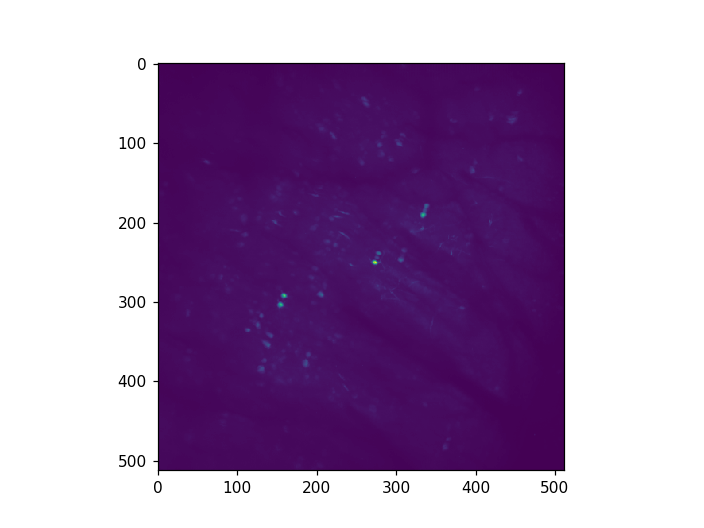

In [20]:
pl.figure()
pl.imshow(zimg)

In [34]:
msks = Ain.reshape(512, 512, 260, order='C').sum(axis=-1)
print(msks.shape)

(512, 512)


<IPython.core.display.Javascript object>


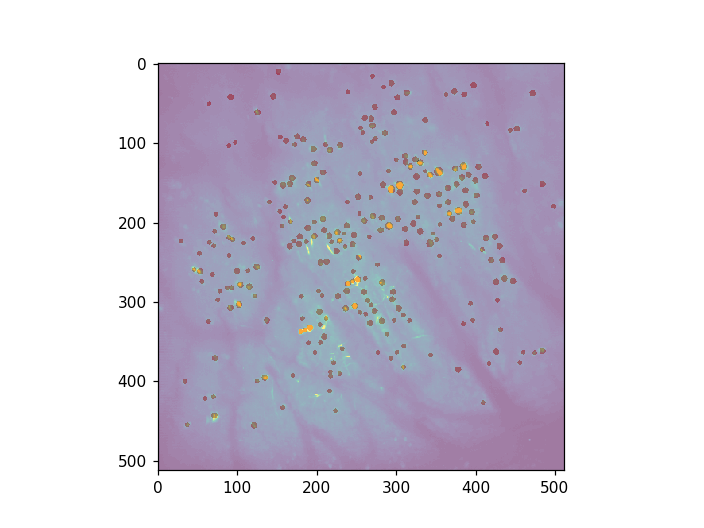

In [35]:
pl.figure()
pl.imshow(zimg.T, vmin=np.percentile(zimg, 1), vmax=np.percentile(zimg, 99.8))
pl.imshow(msks.T, cmap='Reds', alpha=0.5)

#### Update params for seeded

In [42]:

# Reset default patch params to run on full
rf = None          # half-size of the patches in pixels. `None` when seeded CNMF is used.
only_init = False  # has to be `False` when seeded CNMF is used
#gSig = (2, 2)      # expected half size of neurons in pixels, v important for proper component detection

# params object
opts_dict = {'fnames': fnames,
            'decay_time': 0.4,
            'p': 2,
            'nb': 2,
            'rf': rf,
            'only_init': only_init,
            'merge_thr': 0.85,
            'n_pixels_per_process': 100}

opts.change_params(opts_dict)


CNMFParams:

data:

{'caiman_version': '1.6.2',
 'decay_time': 0.4,
 'dims': (512, 512),
 'dxy': (1, 1),
 'fnames': ['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00001.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00002.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00003.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00004.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00005.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00006.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00007.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00008.tif',

In [43]:
opts

CNMFParams:

data:

{'caiman_version': '1.6.2',
 'decay_time': 0.4,
 'dims': (512, 512),
 'dxy': (1, 1),
 'fnames': ['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00001.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00002.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00003.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00004.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00005.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00006.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00007.tif',
            '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00008.tif',

# Get caiman data

In [44]:
# Run cnmf
print("Extracting...")
start_t = time.time()

cnm = cnmf.CNMF(n_processes, params=opts, dview=None, Ain=Ain)
cnm.fit(images)
end_t = time.time() - start_t
print("--> Elapsed time: {0:.2f}sec".format(end_t))
print("A:", cnm.estimates.A.shape)

Extracting...
spatial support for each components given by the user
estimating f


cluster temporary folder: /net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline


IndexError: index 200 is out of bounds for axis 0 with size 1

In [ ]:

# Evaluate components 
print("Evaluatnig components...")
# parameters for component evaluation
min_SNR = 1.5               # signal to noise ratio for accepting a component
rval_thr = 0.85              # space correlation threshold for accepting a component
min_cnn_thr = 0.99          # threshold for CNN based classifier
cnn_lowest = 0.05           # neurons with cnn probability lower than this value are rejected
#cnm_seeded.estimates.restore_discarded_components()
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': rval_thr,
                           'use_cnn': True,
                           'min_cnn_thr': min_cnn_thr,
                           'cnn_lowest': cnn_lowest})

#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier
start_t = time.time()
cnm.estimates.evaluate_components(images, cnm.params, dview=dview)
end_t = time.time() - start_t
print("--> evaluation - Elapsed time: {0:.2f}sec".format(end_t))


In [ ]:
#%% Extract DF/F values
print("Extracting df/f...")
quantileMin = 10 # 8
frames_window_sec = 30.
if 'downsample' in mm_prefix:
    ds_factor = float(mm_prefix.split('downsample-')[-1].split('-')[0]) #opts.init['tsub']
else:
    ds_factor = float(opts.init['tsub'])
fr = float(opts.data['fr'])
frames_window = int(round(frames_window_sec * (fr / ds_factor))) # 250
dff_params = {'quantileMin': quantileMin,
              'frames_window_sec': frames_window_sec,
              'ds_factor': ds_factor,
              'fr': fr,
              'frames_window': frames_window,
              'source': fname_tot}

with open(os.path.join(results_dir, 'seeded_%s_processing-params.json' % prefix), 'w') as f:
    json.dump(dff_params, f, indent=4)
    

start_t = time.time()
cnm.estimates.detrend_df_f(quantileMin=quantileMin, frames_window=frames_window)
end_t = time.time() - start_t
print("--> Elapsed time: {0:.2f}sec".format(end_t))


# save results
save_results = True
if save_results:
    cnm.save(os.path.join(results_dir, 'seeded_%s_results.hdf5' % prefix))
print("Saved results: %s" % os.path.join(results_dir, 'seeded_%s_results.hdf5' % prefix))

print("******DONE!**********")

In [ ]:

Cn = cm.local_correlations(images.transpose(1,2,0))
fig = pl.figure()
pl.imshow(Cn, cmap='gray')
pl.savefig(os.path.join(results_dir, '%s_Cn.png' % prefix))
pl.close()

# Logging

In [37]:
logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    filename=os.path.join(results_dir, 'caiman.log'),
                    level=logging.WARNING)

In [ ]:


# Load data
Yr, dims, T = cm.load_memmap(fname_tot)
images = np.reshape(Yr.T, [T] + list(dims), order='F') #np.reshape(Yr, dims + (T,), order='F')
print("Loaded data:", images.shape)

# Create opts for cnmf
print("Preparing for CNMF extraction...") 
#fnames = get_file_paths(results_dir, prefix=prefix) 
fnames = sorted(glob.glob(os.path.join(results_dir, 'downsample-5', '*.tif')), key=natural_keys)
# fnames = sorted(glob.glob(os.path.join(fovdir,
#                                        'retino_run2', 'raw*','fov1*_.mmap')), key=natural_keys)

print("--> got %i files for extraction" % len(fnames))

In [38]:
nrois, d1, d2 = masks.shape

In [ ]:
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
pl.figure()
pl.imshow(Cn, cmap='gray')

In [ ]:
fig, axes = pl.subplots(2,2, figsize=(12,12))
axes[0, 0].imshow(Ain.reshape((d1, d2, nrois)).sum(axis=-1))
axes[0, 1].imshow(np.sum(masks, axis=0).T)
axes[1, 0].imshow(Cn, cmap='gray')
axes[1, 1].imshow(zimg, cmap='gray', vmin=np.percentile(zimg, 1), vmax=np.percentile(zimg, 99.8))

In [ ]:
masks.shape

In [ ]:
pl.figure(figsize=(10,10))
mr = np.swapaxes(masks, 1, 2) #np.sum(masks, axis=0)
maskr = np.sum(mr, axis=0)
msk = maskr.copy()
msk[maskr==0] = np.nan
pl.imshow(zimg, vmin=np.percentile(zimg, 1), vmax=np.percentile(zimg, 99.8))
pl.imshow( msk)

In [ ]:
prefix

In [ ]:

opts = caiman_params(fnames)

In [ ]:
if seed_manual:
    # params object
    dview=None 
    # Reset default patch params to run on full
    rf = None          # half-size of the patches in pixels. `None` when seeded CNMF is used.
    only_init = False  # has to be `False` when seeded CNMF is used
    gSig = (2, 2)      # expected half size of neurons in pixels, v important for proper component detection
    fr = 44.65 

    opts_dict = {'fnames': fnames,
                 'fr': fr,
                'decay_time': 0.4,
                'p': 2,
                'nb': 2,
                'rf': rf,
                'only_init': only_init,
                'gSig': gSig,
                'ssub': 1,
                'tsub': 1,
                'merge_thr': 0.85,
                'n_pixels_per_process': 1000}

    opts.change_params(opts_dict)
    #opts = params.CNMFParams(params_dict=opts_dict)
    

In [ ]:
print(n_processes)

In [ ]:

# #%% start a cluster for parallel processing 
#(if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=n_processes, single_thread=False)
#n_processes=2
#dview = None
print("--- running on %i processes ---" % n_processes)
print("--- dview: ", dview)


In [26]:
crd = nb_plot_contour(Cn, Ain.astype('float32'), Cn.shape[0], Cn.shape[1], thr=0.99)


In [27]:
if seed_manual:
    start_t = time.time()  
    cnm = cnmf.CNMF(n_processes, params=opts, dview=dview, Ain=Ain) 
    cnm.fit(images)
    end_t = time.time() 
    print("--> Elapsed time: {0:.2f}sec".format(end_t))  

spatial support for each components given by the user
cluster temporary folder: /net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python
cluster temporary folder: /net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python
--> Elapsed time: 1566935821.91sec


In [28]:
cnm.estimates.A.shape

(262144, 238)

In [62]:
Av = images.mean(axis=0)


In [97]:
Ain.shape

(262144, 238)

In [ ]:
AAin2.reshape((d1, d2, nrois)), 1, 2)

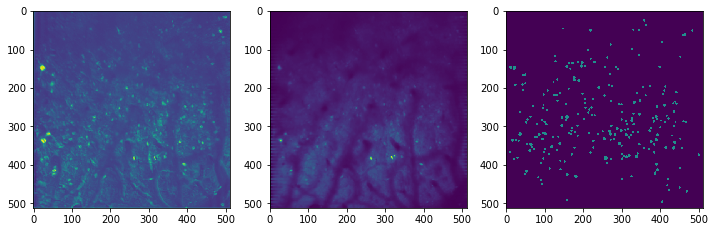

In [98]:
fig, axes = pl.subplots(1,3, figsize=(12,8))
axes[0].imshow(Cn)
axes[1].imshow(Av)
axes[2].imshow(Ain.reshape((d1, d2, nrois)).sum(axis=-1))


In [79]:
Ain.astype('float32').shape

(262144, 238)

In [112]:
crd = nb_plot_contour(Cn, Ain.astype('float32'), Av.shape[0], Av.shape[1], thr=0.99)


In [21]:

#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
cnm.estimates.plot_contours_nb(img=Cn)

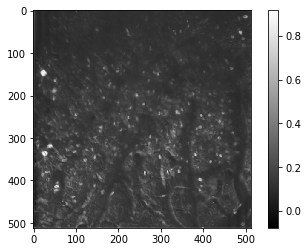

In [24]:
pl.figure()
pl.imshow(Cn, cmap='gray')
pl.colorbar()

pl.savefig(os.path.join(results_dir, '%s_Cn.png' % prefix))

In [25]:
cnm.estimates.A.shape

(262144, 0)

# Try patches

In [19]:
%%capture
#%% RUN CNMF ON PATCHES

# First extract spatial and temporal components on patches and combine them
# for this step deconvolution is turned off (p=0)
opts.change_params({'p': 0})
cnm = cnmf.CNMF(n_processes, params=opts, dview=dview)
cnm = cnm.fit(images)

In [19]:
#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
cnm.estimates.plot_contours_nb(img=Cn)

In [20]:
cnm.estimates.plot_contours_nb(img=Cn)

# Rerun on full

In [89]:
# %%capture
# #%% RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution 
# p=1

# # Reset default patch params to run on full
# rf = None          # half-size of the patches in pixels. `None` when seeded CNMF is used.
# only_init = False  # has to be `False` when seeded CNMF is used
# gSig = (2, 2)      # expected half size of neurons in pixels, v important for proper component detection
# cnm.params.change_params({'p': p, 'rf': rf, 'only_init': only_init, 'gSig': gSig})
# cnm2 = cnm.fit(images, dview=None)    


In [20]:
cnm.estimates.A.shape

(262144, 1108)

In [21]:

#
p=2
cnm.params.change_params({'p': p})
cnm2 = cnm.refit(images, dview=None)

cluster temporary folder: /net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python


cluster temporary folder: /net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python


In [22]:
cnm2.estimates.A.shape

(262144, 1108)

In [23]:
os.listdir(results_dir)

['JC085-20190622-FOV1_zoom2p0x-retino_run1_mc-rigid.npz',
 'seed-cnm_seeded-JC085-20190622-FOV1_zoom2p0x-retino_run1_results.hdf5',
 'JC085-20190622-FOV1_zoom2p0x-retino_run1_processing-params.json',
 'patch-cnm_JC085-20190622-FOV1_zoom2p0x-retino_run1_results.hdf5',
 'memmap',
 'seeded-JC085-20190622-FOV1_zoom2p0x-retino_run1_processing-params.json']

In [25]:
print(cnm2.estimates.A.shape)

(262144, 1108)


In [44]:
cnm.params

CNMFParams:

data:

{'caiman_version': '1.6.2',
 'decay_time': 0.4,
 'dims': (512, 512),
 'dxy': (1, 1),
 'fnames': ['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/downsample-5/file00001_fov1_gratings_00001.tif',
            '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/downsample-5/file00002_fov1_gratings_00002.tif',
            '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/downsample-5/file00003_fov1_gratings_00003.tif',
            '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/downsample-5/file00004_fov1_gratings_00004.tif',
            '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/downsample-5/file00005_fov1_gratings_00005.tif',
            '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/downsample-5/file00006_fov1_gratings_00006.tif',
            '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/downsa

# Evaluate components

In [26]:
# parameters for component evaluation
min_SNR = 1.5               # signal to noise ratio for accepting a component
rval_thr = 0.85              # space correlation threshold for accepting a component
min_cnn_thr = 0.99          # threshold for CNN based classifier
cnn_lowest = 0.05           # neurons with cnn probability lower than this value are rejected
#cnm_seeded.estimates.restore_discarded_components()
cnm2.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': rval_thr,
                           'use_cnn': True,
                           'min_cnn_thr': min_cnn_thr,
                           'cnn_lowest': cnn_lowest})

#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

In [27]:
cnm2.estimates.evaluate_components(images, cnm2.params, dview=dview)


USING MODEL:/n/home00/juliana.rhee/caiman_data/model/cnn_model.json
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


1108/1108 [==============================] - 6s 6ms/sample


In [28]:
cnm2.estimates.select_components(use_object=True)

In [29]:
cnm2.estimates.A.shape

(262144, 887)

In [31]:
#%% PLOT accepted COMPONENTS
cnm2.estimates.plot_contours_nb(img=Cn, idx=cnm2.estimates.idx_components)

In [32]:
cnm.estimates.plot_contours_nb(img=Cn) #, idx=cnm.estimates.idx_components)

# Extract dff

In [30]:
prefix

'JC085-20190622-FOV1_zoom2p0x-retino_run1'

In [31]:
#%% Extract DF/F values
print("Extracting df/f...")
quantileMin = 10 # 8
frames_window_sec = 30.
if 'downsample' in mm_prefix:
    ds_factor = float(mm_prefix.split('downsample-')[-1]) #opts.init['tsub']
else:
    ds_factor = float(opts.init['tsub'])
fr = float(opts.data['fr'])
frames_window = int(round(frames_window_sec * (fr / ds_factor))) # 250
dff_params = {'quantileMin': quantileMin,
              'frames_window_sec': frames_window_sec,
              'ds_factor': ds_factor,
              'fr': fr,
              'frames_window': frames_window,
              'source': fname_tot}

with open(os.path.join(results_dir, '%s_processing-params.json' % prefix), 'w') as f:
    json.dump(dff_params, f, indent=4)


Extracting df/f...


In [32]:
#%% Extract DF/F values
cnm2.estimates.detrend_df_f(quantileMin=quantileMin, frames_window=frames_window)

# Save

In [33]:
save_results=True
if save_results:
    cnm2.save(os.path.join(results_dir, 'patch-cnm_%s_results.hdf5' % prefix))

/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [ ]:

#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
cnm2.estimates.plot_contours_nb(img=Cn)

In [37]:
cnm2.estimates.nb_view_components(img=Cn, denoised_color='red') #, idx=cnm.estimates.idx_components)


NameError: name 'Cn' is not defined

In [43]:
cnm.estimates.f.shape

(1, 29504)

In [ ]:
background = cnm.estimates.b.dot(cnm.estimates.f)


In [ ]:
pl.figure(figsize=(15,4))
pl.plot(background)

In [ ]:
background.shape

In [132]:
 (cnm.params.get('init', 'method_init') == 'corr_pnr' and
                    cnm.params.get('init', 'ring_size_factor') is not None)

False

# Load data

In [11]:
from caiman.source_extraction.cnmf.cnmf import load_CNMF

In [15]:
results_path = glob.glob(os.path.join(results_dir, 'patches-%s*_results.hdf5' % prefix))[0]
cnm = load_CNMF(results_path, n_processes=n_processes)

/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [17]:
cnm.estimates.A.shape

(262144, 0)